In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.tree import _tree, plot_tree

from matplotlib.gridspec import GridSpec
import joblib
from tree_utils import *


In [17]:
df = pd.read_csv("/Users/carolbarroco/Documents/RecomendSisKNN/TG2 RecommendSys/GitHub/T2-Indroducao-Ciencia-de-Dados/Data/MPBROCKMETAL_KGDataSet.csv")

In [4]:


# === 1. Prepare Data ===
X = df.iloc[:, 6:20]
y = df["track_genre"]
feature_names = X.columns

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=feature_names)
joblib.dump(scaler, "scaler.pkl")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = label_encoder.classes_
joblib.dump(label_encoder, "label_encoder.pkl")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42
)

# === 2. Train Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion="entropy")
clf.fit(X_train, y_train)

# === 3. Find Best Tree by Accuracy ===
best_accuracy = 0
best_tree_index = 0

for i, tree in enumerate(clf.estimators_):
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_tree_index = i

print(f"Best tree index (accuracy): {best_tree_index}")
print(f"Best tree accuracy: {best_accuracy:.4f}")

best_tree = clf.estimators_[best_tree_index]

rules = extract_rules(
    tree=best_tree,
    feature_names=X_train.columns,
    X_data=X_train,
    index_data=X_train.index
)
rules_df = pd.DataFrame(rules)

print("\nSample of extracted rules:")
print(rules_df.head())

# === 5. Evaluation: Forest vs Best Tree ===
forest_pred = clf.predict(X_test)
tree_pred = best_tree.predict(X_test)

forest_acc = accuracy_score(y_test, forest_pred)
tree_acc = accuracy_score(y_test, tree_pred)

forest_probs = clf.predict_proba(X_test)
tree_probs = best_tree.predict_proba(X_test)

forest_logloss = log_loss(y_test, forest_probs, labels=range(len(class_labels)))
tree_logloss = log_loss(y_test, tree_probs, labels=range(len(class_labels)))

print(f"\nRandom Forest accuracy: {forest_acc:.4f}")
print(f"Best Tree accuracy:     {tree_acc:.4f}")
print(f"Random Forest log loss: {forest_logloss:.4f}")
print(f"Best Tree log loss:     {tree_logloss:.4f}")



# Save the best tree to a file
joblib.dump(best_tree, "best_tree.pkl")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/uti

Best tree index (accuracy): 98
Best tree accuracy: 0.9520

Sample of extracted rules:
        feature  threshold            depth  node  \
0    popularity   0.104167  1.584250      0     0   
1  acousticness   0.004169  0.511205      1     1   
2           key   0.136364  0.584728      2     2   
3   duration_ms   0.221093  1.000000      3     3   
4      loudness   0.736232  0.918296      4     5   

                                        data_indices  
0  Index([2922,  340, 1099, 1543,  748, 2755,  66...  
1  Index([1099, 1543, 1446, 1124, 1783, 1213, 170...  
2  Index([1213, 1244, 1623, 1234, 2044, 1983, 115...  
3  Index([1244, 1242, 1376, 2043, 1933, 2046, 188...  
4  Index([1244, 1242, 1376, 2043, 2046, 1889, 203...  

Random Forest accuracy: 0.9733
Best Tree accuracy:     0.9520
Random Forest log loss: 0.1421
Best Tree log loss:     1.7301


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


['best_tree.pkl']

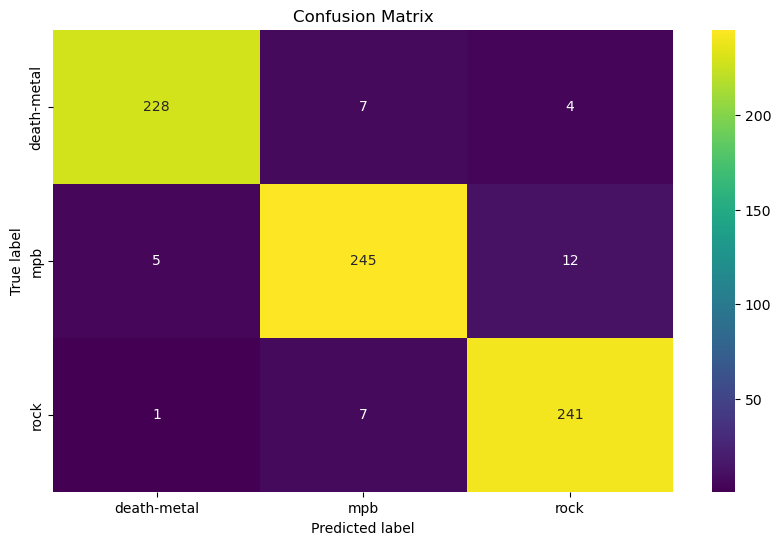

In [5]:
y_decoded = label_encoder.inverse_transform(y_encoded)

cm = confusion_matrix(y_test, tree_pred)
class_labels = label_encoder.classes_

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

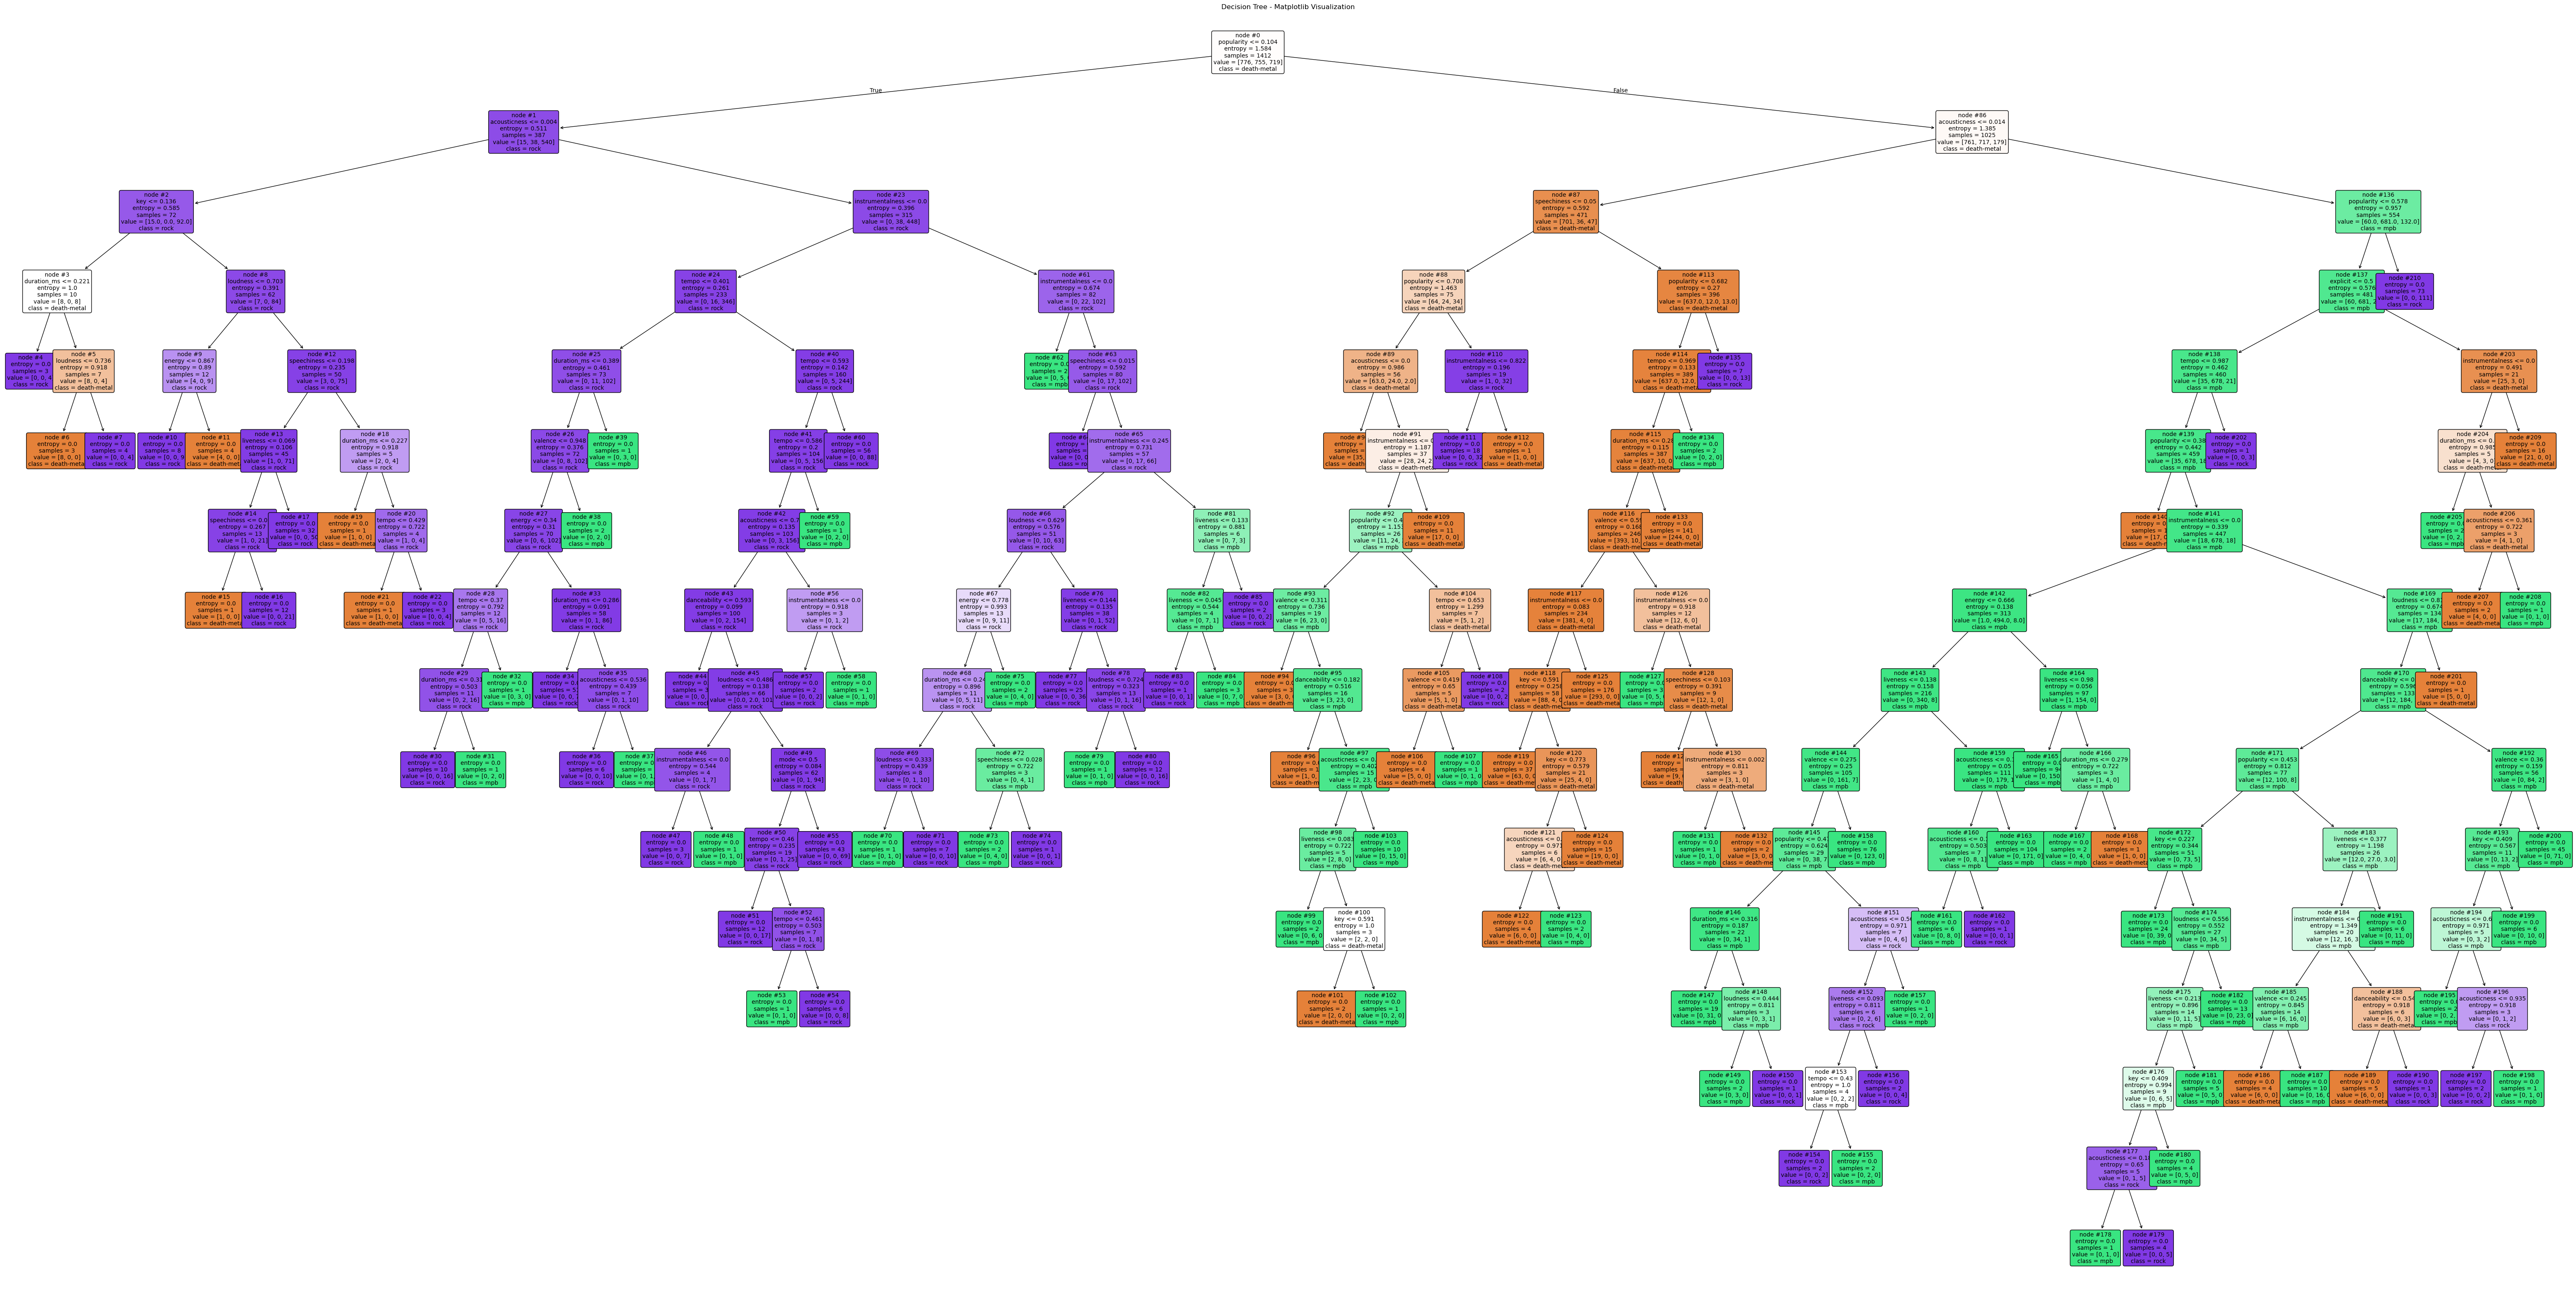

In [6]:

original_labels = label_encoder.inverse_transform(y_encoded)
class_names = label_encoder.classes_  # Returns array like: ['black metal' 'mpb' 'rock']


plt.figure(figsize=(80, 40))  
plot_tree(best_tree,
          feature_names=feature_names,
          class_names=class_names,  
          filled=True,
          node_ids=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree - Matplotlib Visualization")
plt.show()


In [7]:
importances = pd.Series(best_tree.feature_importances_, index=X.columns)
importances

popularity          0.466652
duration_ms         0.014771
explicit            0.024269
danceability        0.006888
energy              0.008975
key                 0.012601
loudness            0.020669
mode                0.000530
speechiness         0.037368
acousticness        0.312230
instrumentalness    0.041265
liveness            0.010938
valence             0.021439
tempo               0.021405
dtype: float64

In [34]:


specific_rules = pd.concat([rules_df.loc[rules_df["node"] == 1], rules_df.loc[rules_df["node"] == 86],rules_df.loc[rules_df["node"] == 87],rules_df.loc[rules_df["node"] == 136]])

print(specific_rules)


         feature  threshold            depth  node  \
1   acousticness   0.004169  0.511205      1     1   
43  acousticness   0.013880  1.385338      1    86   
44   speechiness   0.050096  0.591845      2    87   
68    popularity   0.578125  0.957109      2   136   

                                         data_indices  
1   Index([1099, 1543, 1446, 1124, 1783, 1213, 170...  
43  Index([2922,  340,  748, 2755,  662,  480, 213...  
44  Index([2922, 2755, 2138, 1453, 2952, 2020, 270...  
68  Index([ 340,  748,  662,  480,  871,  549,  74...  


,index,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0.687500,0.150843,0.0,0.812223,0.496964,0.090909,0.651958,0.0,0.033077,0.498480,0.376931,0.128426,0.454830,0.390933
1,1,0.677083,0.071344,0.0,0.761011,0.421959,0.090909,0.380436,0.0,0.088462,0.480243,0.087230,0.140745,0.547781,0.391087
2,2,0.510417,0.288082,0.0,0.660863,0.650975,0.636364,0.610140,0.0,0.032885,0.765957,0.000004,0.726927,0.658486,0.438057
3,3,0.510417,0.233672,0.0,0.635826,0.419959,0.363636,0.500638,0.0,0.044615,0.825735,0.000000,0.107894,0.555091,0.289413
4,4,0.520833,0.307027,0.0,0.601684,0.329953,0.636364,0.362521,1.0,0.012500,0.603850,0.000001,0.068781,0.367102,0.545707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,0.208333,0.074629,0.0,0.481052,0.993000,0.090909,0.747963,1.0,0.200000,0.000438,0.030999,0.328611,0.139426,0.493490
2996,2996,0.000000,0.247932,0.0,0.362695,0.993000,0.636364,0.815942,1.0,0.207692,0.000079,0.006406,0.112001,0.019112,0.332490
2997,2997,0.218750,0.165407,1.0,0.290998,0.975998,0.181818,0.860754,0.0,0.492308,0.000033,0.010917,0.300893,0.487206,0.207682
2998,2998,0.229167,0.130835,1.0,0.353591,0.994000,0.545455,0.950574,1.0,0.198077,0.038501,0.000276,0.351196,0.451697,0.336427


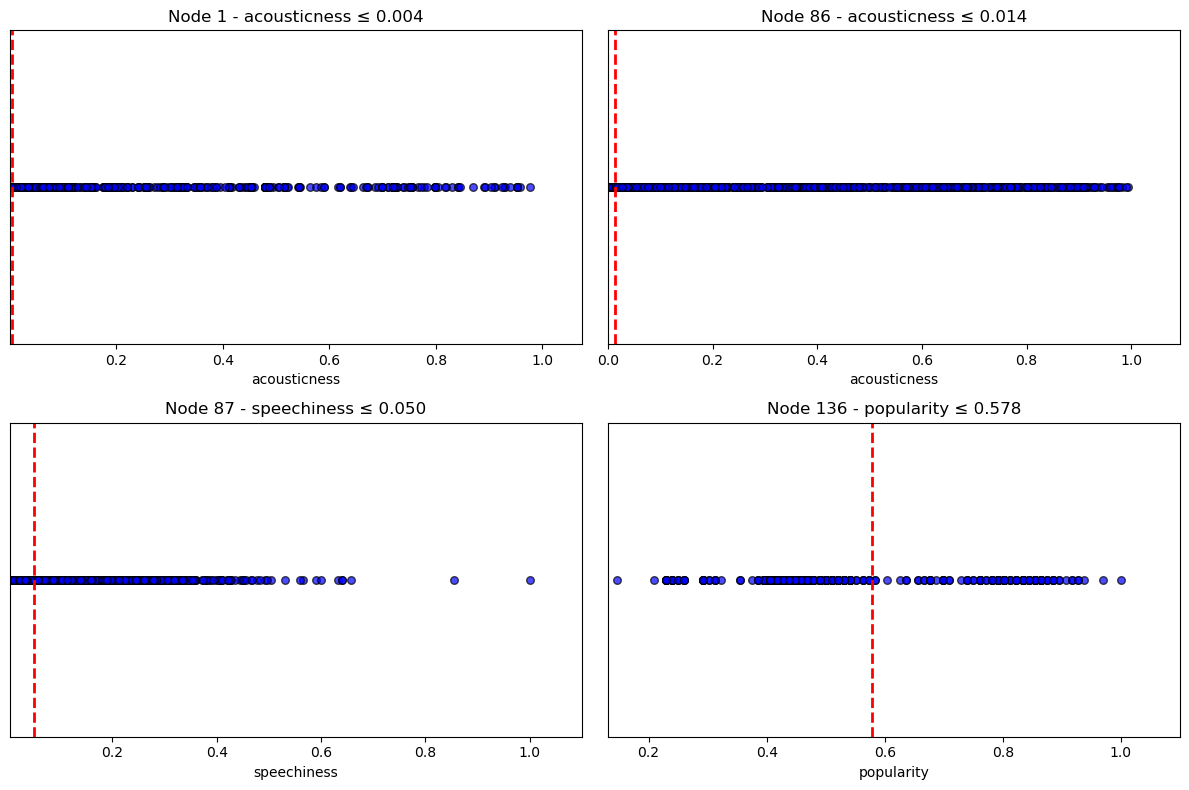

In [35]:


def plot_specific_thresholds(df, specific_rules, index_col="index", scatter_color='blue'):
    n_rules = len(specific_rules)
    
    # Define grid size for 4 plots (2 rows x 2 cols)
    n_cols = 2
    n_rows = int(np.ceil(n_rules / n_cols))
    
    fig = plt.figure(figsize=(6 * n_cols, 4 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig)
    
    for plot_idx, (_, rule) in enumerate(specific_rules.iterrows()):
        feature = rule['feature']
        threshold = rule['threshold']
        data_indices = rule['data_indices']

        # Filter rows using the index_col and the indices from specific_rules
        mask = df[index_col].isin(data_indices)
        subset = df.loc[mask]
        
        # Reorder subset to maintain order in data_indices
        subset = subset.set_index(index_col).loc[data_indices].reset_index()
        
        x = subset[feature].values
        
        if len(x) == 0:
            print(f"Warning: No data found for feature '{feature}' at node {rule['node']} with given indices.")
            continue
        
        ax = fig.add_subplot(gs[plot_idx])
        
        x_min, x_max = x.min() - 0.1 * abs(x.min()), x.max() + 0.1 * abs(x.max())
        ax.set_xlim(x_min, x_max)
        
        # Plot all points in the subset as blue dots on x-axis (y=0)
        ax.scatter(x, np.zeros_like(x), color=scatter_color, edgecolor='k', s=30, alpha=0.7)
        
        # Plot vertical threshold line
        ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
        
        ax.set_xlabel(feature)
        ax.set_yticks([])
        ax.set_title(f'Node {rule["node"]} - {feature} ≤ {threshold:.3f}')
    
    plt.tight_layout()
    plt.show()



plot_specific_thresholds(X.reset_index(), specific_rules)